In [1]:
%matplotlib inline

In [2]:
import pylab
import numpy as np
import eqcatalog

Read earthquake sequence from database

In [3]:
cat = eqcatalog.rob.query_local_eq_catalog(start_date='2021-01-01', region=(6.0, 6.3, 50.58, 50.85))
cat.print_info()

+-------------------+-------------------------------------------------------+
|     Parameter     |                         Value                         |
+-------------------+-------------------------------------------------------+
|    Catalog name   | ROB Catalog 2021-01-01T00:00:00 - 2021-01-07T07:53:13 |
| Earthquake number |                           29                          |
|     Start time    |                2021-01-01T00:00:00.000                |
|      End time     |                2021-01-07T07:53:13.000                |
|  Longitude bounds |                    6.1433 / 6.2433                    |
|  Latitude bounds  |                   50.5898 / 50.8408                   |
|    Depth range    |                     8.5 / 15.4 km                     |
|         ML        |                n=29, min=-1.4, max=2.6                |
|    Event types    |                       ke (n=29)                       |
+-------------------+-------------------------------------------

Check if different declustering windows/methods identify sequence as 1 cluster

In [4]:
dc_method = eqcatalog.declustering.LinkedWindowMethod()

In [5]:
Mrelation = {'ML': 'GruenthalEtAl2009'}
for dc_window_name in ('GardnerKnopoff1974', 'Uhrhammer1986', 'Gruenthal2009'):
    print(dc_window_name)
    dc_window = eqcatalog.declustering.get_window_by_name(dc_window_name)
    dc_result = dc_method.analyze_clusters(cat, dc_window, Mrelation)
    dc_result.print_info()
    print()

GardnerKnopoff1974
Number of clusters identified: 1
Max. cluster length: 29
Num. clustered/unclustered events: 29 / 0
Num. dependent/independent events: 28 / 1

Uhrhammer1986
Number of clusters identified: 2
Max. cluster length: 14
Num. clustered/unclustered events: 16 / 13
Num. dependent/independent events: 14 / 15

Gruenthal2009
Number of clusters identified: 1
Max. cluster length: 29
Num. clustered/unclustered events: 29 / 0
Num. dependent/independent events: 28 / 1



In [6]:
dc_method = eqcatalog.declustering.ReasenbergMethod()
dc_window = eqcatalog.declustering.Reasenberg1985Window()
dc_result = dc_method.analyze_clusters(cat, Mrelation, dc_window)
print('Reasenberg1985')
dc_result.print_info()

Reasenberg1985
Number of clusters identified: 2
Max. cluster length: 6
Num. clustered/unclustered events: 8 / 21
Num. dependent/independent events: 6 / 23


Determine completeness magnitude Mc

OpenQuake version: 3.8.1


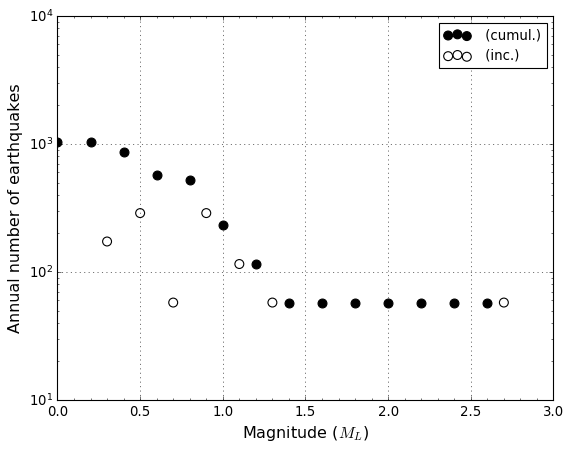

In [7]:
cat.default_completeness = None
mfd = cat.get_incremental_mfd(0, 3, 0.2, Mtype='ML')
mfd.plot()

Estimate parameters K, c, p of Omori law based on elapsed times since mainshock

In [8]:
mainshock = cat.get_event_by_id(11630)

In [9]:
dc_method = eqcatalog.declustering.LinkedWindowMethod()
dc_window = eqcatalog.declustering.Gruenthal2009Window()

In [10]:
aftershocks = dc_method.get_aftershocks(mainshock, cat, dc_window, Mrelation)

In [11]:
Mc = 0.2
cc_aftershocks = aftershocks.subselect(Mmin=Mc, Mtype='ML')
print(len(cc_aftershocks))

16


In [12]:
as_time_deltas = cc_aftershocks.get_time_deltas(mainshock.datetime)
as_time_deltas = eqcatalog.time.fractional_time_delta(as_time_deltas, 'D')
as_time_deltas

array([ 0.29376157,  0.33158565,  0.34032407,  0.34800926,  0.75746528,
        0.83662037,  0.85241898,  0.96208333,  0.97803241,  0.99259259,
        1.1765625 ,  1.97284722,  2.91003472,  3.90127315,  4.195625  ,
        4.50474537])

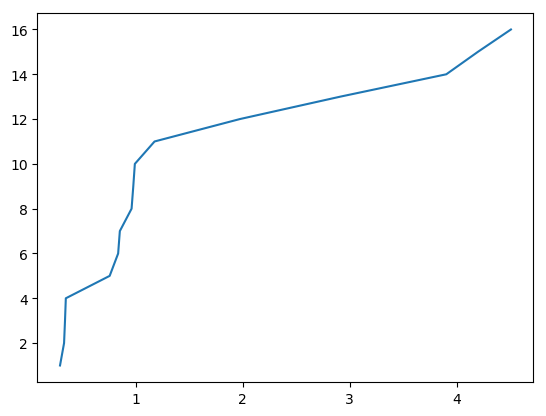

In [13]:
pylab.plot(as_time_deltas, np.arange(len(cc_aftershocks))+1)

In [14]:
(K, c, p) = eqcatalog.omori.estimate_omori_params(as_time_deltas)
print(K, c, p)

21.8289583466 1.70746259623 1.49405921876


C:\Miniconda3\envs\py3\lib\site-packages\scipy\optimize\_minimize.py:534: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Define Omori law, including completeness magnitude and mainshock magnitude. Default time unit is days.

In [15]:
omlaw = eqcatalog.omori.OmoriLaw(K, c, p, Mc, mainshock.ML)

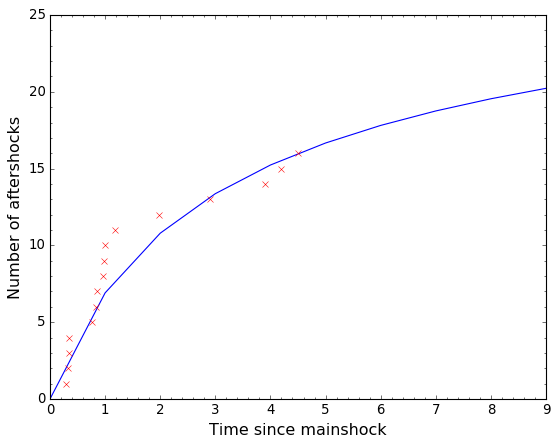

In [16]:
num_days = 10
ax = omlaw.plot_cumulative(np.arange(num_days), fig_filespec='wait')
ax.plot(as_time_deltas, np.arange(len(cc_aftershocks))+1, 'rx')

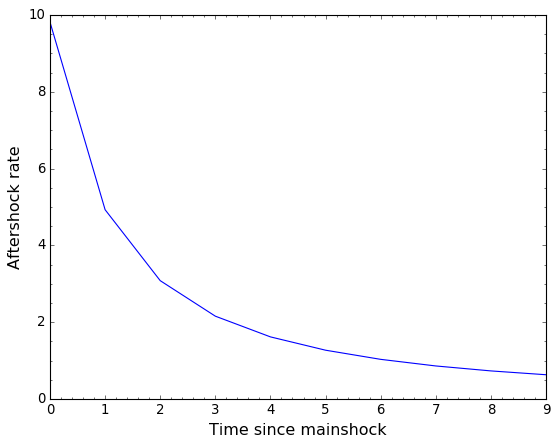

In [17]:
omlaw.plot_rate(np.arange(num_days))

Some calculations. All predictions are valid for M>=Mc

In [18]:
end_time = 5
omlaw.get_num_aftershocks(end_time)

16.666406691872325

In [19]:
start_time = 5
end_time = 10
omlaw.get_num_aftershocks(end_time, start_time)

4.1508393197776

In [20]:
background_rate = 1./30
omlaw.get_aftershock_duration(background_rate)

75.01126106631477

In [21]:
n = 1
start_time = 5
end_time = 6
omlaw.get_prob_n_aftershocks(n, end_time, start_time)

0.3643723654482135

In [22]:
start_time = 5
end_time = 6
omlaw.get_prob_one_or_more_aftershocks(end_time, start_time)

0.6817348252958253

In [23]:
n = 15
omlaw.get_time_delta_for_n_aftershocks(n)

3.8581525791415765

We can do some predictions, but not about magnitude!

In order to do that, we need to combine the Omori law with the Gutenberg-Richter relation. This involves converting K to the magnitude-independent productivity parameter A.

Note that it would be better to convert ML to MW for this exercise

In [24]:
b_value = 0.9
gr_omlaw = omlaw.to_gr_omori_law(b_value)

In [26]:
gr_omlaw.K

21.828958346575938

Now we can compute probabilities for higher Mc, simply by changing the Mc property of the Base10GROmoriLaw instance

In [40]:
gr_omlaw.Mc = 4

In [30]:
start_time = 5
end_time = 35
gr_omlaw.get_prob_one_or_more_aftershocks(end_time, start_time)

0.00046911680770878039

In [41]:
start_time = 5
end_time = 10
num_samples = 100
gr_omlaw.get_random_num_aftershocks(end_time, start_time, num_samples)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
gr_omlaw.Mc = 2
gr_omlaw.get_random_num_aftershocks(end_time, start_time, num_samples)

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0])